# Importing 2010 Urban Centers Census Data / Wikipedia Table
## Making the Data Usable

In [53]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
city_url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(city_url)
soup = BeautifulSoup(response.text, 'html.parser')
city_table = soup.find('table', {'class': "wikitable sortable"})
city_df = pd.read_html(str(city_table))
city_df = pd.DataFrame(city_df[0])
city_df['Location'][0] = r"""40°39′N 73°55′W / 40.66°N 73.93°W""" # I had to manually input this from the table. I double-checked the rest of the table and this appears to be the only anomaly.
city_df.columns = ['2021 Rank', 'City', 'State', '2021 Estimate', '2020 Census', 'Change', '2020 Land Area in Square Miles', '2020 Land Area in Square Kilometers', '2020 Population Density in Per Square Mile', '2020 Population Density in Per Square Kilometer', 'Location']
city_df['2020 Land Area in Square Miles'] = city_df['2020 Land Area in Square Miles'].str.replace(',', '').str.extract('(\d+\.?\d*)').astype(float)
city_df['2020 Land Area in Square Kilometers'] = city_df['2020 Land Area in Square Kilometers'].str.replace(',', '').str.extract('(\d+\.?\d*)').astype(float)
city_df['2020 Population Density in Per Square Mile'] = city_df['2020 Population Density in Per Square Mile'].str.replace(',', '').str.extract('(\d+\.?\d*)').astype(float)
city_df['2020 Population Density in Per Square Kilometer'] = city_df['2020 Population Density in Per Square Kilometer'].str.replace(',', '').str.extract('(\d+\.?\d*)').astype(float)
city_df['City'] = city_df['City'].str.replace(r"\[.*\]","")
city_df['State'] = city_df['State'].str.replace(r"\[.*\]","")
city_df['Latitude (North)'] = city_df['Location'].str.split('/').str[1].str.split('°').str[0].str.extract('(\d+\.?\d*)').astype(float)
city_df['Longitude (West)'] = city_df['Location'].str.split('/').str[1].str.split('°').str[1].str.extract('(\d+\.?\d*)').astype(float)
city_df[city_df['Change'].isna()] # Richmond (97) and Santa Maria (281) are missing the change value.
for v in city_df[city_df['Change'].isna()]:
    city_df['Change'] = city_df[city_df['Change'].isna()] = (city_df['2021 Estimate'] - city_df['2020 Census']) / city_df['2021 Estimate']

<ipython-input-53-9c75bf56cff1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['Location'][0] = r"""40°39′N 73°55′W / 40.66°N 73.93°W""" # I had to manually input this from the table. I double-checked the rest of the table and this appears to be the only anomaly.
<ipython-input-53-9c75bf56cff1>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  city_df['City'] = city_df['City'].str.replace(r"\[.*\]","")
<ipython-input-53-9c75bf56cff1>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  city_df['State'] = city_df['State'].str.replace(r"\[.*\]","")


# State by State Comparisons
## From Ballotpedia

In [54]:
state_url = 'https://ballotpedia.org/United_States_school_districts'
state_response = requests.get(state_url)
soup = BeautifulSoup(state_response.text, 'html.parser')
state_table = soup.find('table', {'class': "wikitable sortable"})
state_df = pd.read_html(str(state_table))
state_df = pd.DataFrame(state_df[0])
state_df['State Superintendent'].isna().sum() # Only Ohio is missing. I will manually add Ohio's superintendant.
state_df[state_df['State Superintendent'].isna()] = 'Stephanie K. Siddens'

In [55]:
state_df['Graduation rate'] = state_df['Graduation rate'].str.strip('%')
state_df['Graduation rate'] = pd.to_numeric(state_df['Graduation rate'], errors = 'coerce')

# Merging the two Dataframes.

In [56]:
specs_df = city_df.merge(state_df, on = 'State')
specs_df.to_csv('specs_df.csv')

# Visualizations for better data compilation

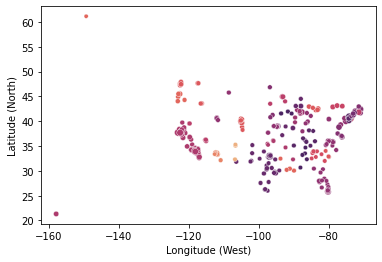

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x = -1 * specs_df['Longitude (West)'], y = specs_df['Latitude (North)'], palette = 'flare', size = specs_df['2020 Population Density in Per Square Mile'], hue = specs_df['Graduation rate'], legend = False)
plt.show()